# Insurance cost prediction using linear regression

미국 의료 보험 데이터 세트 사용: https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset

* AGE
* SEX
* BMI
* CHILDREN
* SMOKER
* REGION
* CHARGES -> Target

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [24]:
# Hyperparameters
batch_size=64
learning_rate=1e-6

# Other constants
DATASET_URL = "https://gist.github.com/BirajCoder/5f068dfe759c1ea6bdfce9535acdb72d/raw/c84d84e3c80f93be67f6c069cbdc0195ec36acbd/insurance.csv"
DATA_FILENAME = "insurance.csv"
TARGET_COLUMN = 'charges'
input_size = 5
output_size = 1 

## Dataset & Data loaders

In [4]:
download_url(DATASET_URL, '.')
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head()

Using downloaded and verified file: .\insurance.csv


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [10]:
CATEGORICAL_COLUMNS = ['sex', 'smoker']

for col in CATEGORICAL_COLUMNS:
    dataframe[col] = dataframe[col].astype('category').cat.codes
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


In [13]:
dataframe = dataframe.drop('region', axis=1)
dataframe.head()

,age,sex,bmi,children,smoker,charges
0,19,0,27.900,0,1,16884.92400
1,18,1,33.770,1,0,1725.55230
2,28,1,33.000,3,0,4449.46200
3,33,1,22.705,0,0,21984.47061
4,32,1,28.880,0,0,3866.85520


In [15]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop(TARGET_COLUMN, axis=1).values
targets = dataframe[[TARGET_COLUMN]].values
inputs.shape, targets.shape

((1338, 5), (1338, 1))

In [16]:
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [1238, 100])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

## Model

In [28]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch
        out = self(inputs)
        loss = F.mse_loss(out, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        out = self(inputs)
        loss = F.mse_loss(out, targets)   
        # Tensor가 기록을 추적하는 것을 중단하게 하려면, 
        # .detach() 를 호출하여 연산 기록으로부터 분리(detach)하여 이후 연산들이 추적되는 것을 방지할 수 있습니다.
        # .no_grad()를 적용한 텐서와 기능적으로는 차이가 없습니다.
        return {'val_loss': loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        if (epoch + 1) % 20 == 0:
            print('Epoch [{}], val_loss: {:.4f}'.format(epoch+1, result['val_loss']))

In [29]:
model = InsuranceModel()

## Training

In [19]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [30]:
result = evaluate(model, val_loader)
result

{'val_loss': 273863424.0}

In [31]:
history1 = fit(100, learning_rate, model, train_loader, val_loader)

Epoch [20], val_loss: 105631992.0000
Epoch [40], val_loss: 106036016.0000
Epoch [60], val_loss: 106342456.0000
Epoch [80], val_loss: 106405600.0000
Epoch [100], val_loss: 106307960.0000


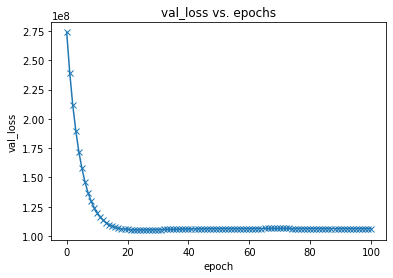

In [33]:
losses = [r['val_loss'] for r in [result] + history1]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

In [34]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(xb).item()

In [35]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([48.0000,  1.0000, 32.3000,  1.0000,  0.0000])
Target:  8765.2490234375
Prediction: 15680.388671875
